In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# source model name to load the network weights
source_model = 'model-lsr'

shuffle_clusters = False

# load the training data
data = DataModel('data-mtx-top-8.npz', 
                 batch_size = 128, validation_percent = .1, test_percent = .2, 
                 weight_compton=1, weight_non_compton=.75)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, source_model)

In [3]:
# define and create the neural network architecture as in the source model
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.000, limbs_l2=.000)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
#LOADING SOURCE MODEL
ai.load(source_model, optimizer=False)
ai.compile_model()

In [5]:
#compute the predictions for all the data
predictions = ai.data._denormalize_targets(ai.predict(ai.data.get_features()))

#load all the targets, e/p cluster positions (last two) are not needed
targets = ai.data._denormalize_targets(ai.data._targets[:,:-2])

#assert the matrix shape is the same
assert predictions.shape == targets.shape

In [6]:
# compute the absolute relative difference in energy
e_energy_diff = np.abs(targets[:,0] * (targets[:,1] - predictions[:,1]) / (targets[:,1]+1e-20))
p_energy_diff = np.abs(targets[:,0] * (targets[:,2] - predictions[:,2]) / (targets[:,2]+1e-20))

# compute the euclidean distance in position
e_pos_diff = targets[:,0] * utils.euclidean_distance_np(targets[:,3:6], predictions[:,3:6])
p_pos_diff = targets[:,0] * utils.euclidean_distance_np(targets[:,6:9], predictions[:,6:9])

In [7]:
# apply energy threshold at .6 and compute energy quality
enrg_threshold = .7
e_energy_qlty = targets[:,0] - np.minimum(e_energy_diff,enrg_threshold) / enrg_threshold
p_energy_qlty = targets[:,0] - np.minimum(p_energy_diff,enrg_threshold) / enrg_threshold

# apply position threshold at mean + .6 sigma and compute position quality
sigma = 1.2
e_sigma = e_pos_diff[targets[:,0]==1].mean() + e_pos_diff[targets[:,0]==1].std() * sigma
p_sigma = p_pos_diff[targets[:,0]==1].mean() + p_pos_diff[targets[:,0]==1].std() * sigma
e_pos_qlty = targets[:,0] - np.minimum(e_pos_diff, e_sigma) / e_sigma
p_pos_qlty = targets[:,0] - np.minimum(p_pos_diff, p_sigma) / p_sigma

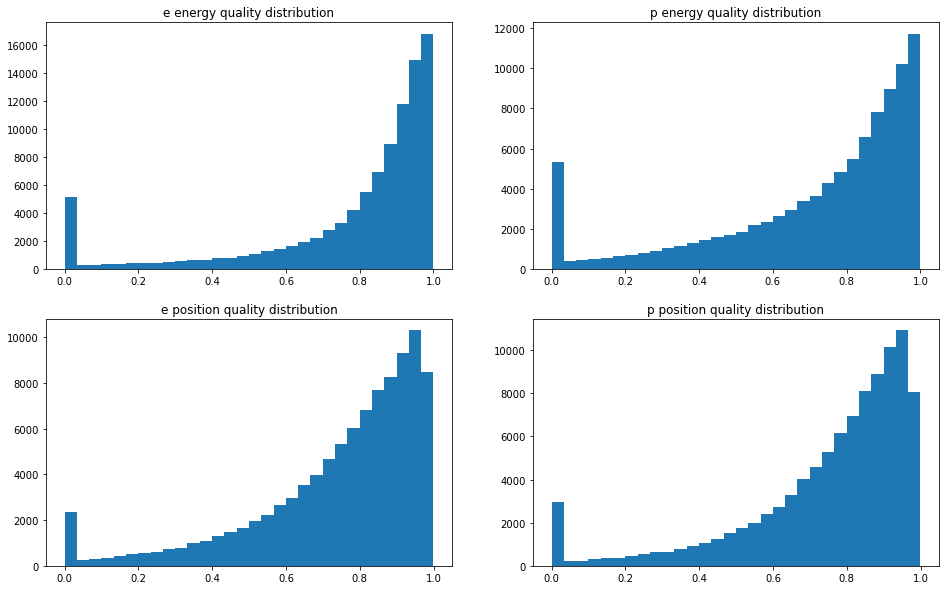

In [8]:
#plot the distribution of quality vectors
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.title('e energy quality distribution')
plt.hist(e_energy_qlty[targets[:,0]==1], bins=30)
plt.subplot(2,2,2)
plt.title('p energy quality distribution')
plt.hist(p_energy_qlty[targets[:,0]==1], bins=30)
plt.subplot(2,2,3)
plt.title('e position quality distribution')
plt.hist(e_pos_qlty[targets[:,0]==1], bins=30)
plt.subplot(2,2,4)
plt.title('p position quality distribution')
plt.hist(p_pos_qlty[targets[:,0]==1], bins=30)
plt.show()

In [9]:
def stats(l):
    s = l[targets[:,0]==1]
    print('mean:', s.mean())
    print('median:', np.quantile(s,.5))
    
print('e energy')
stats(e_energy_qlty)

print('\np energy')
stats(p_energy_qlty)

print('\ne pos')
stats(e_pos_qlty)

print('\np pos')
stats(p_pos_qlty)

e energy
mean: 0.7772552066980309
median: 0.8808944653432598

p energy
mean: 0.71536487682143
median: 0.8128353371121457

e pos
mean: 0.7423623552558445
median: 0.8099547065852731

p pos
mean: 0.7502334659396334
median: 0.8202725166189176


In [10]:
# denormalize features, targets, and reco
ai.data._features = ai.data._denormalize_features(ai.data._features)
ai.data._targets = ai.data._denormalize_targets(ai.data._targets)
ai.data._reco = ai.data._denormalize_targets(ai.data._reco)

In [11]:
# save the quality vectors along with other training data

output_name = 'data-qlty-top-8.npz'
qlty = np.concatenate([e_energy_qlty.reshape(-1,1), 
                       p_energy_qlty.reshape(-1,1), 
                       e_pos_qlty.reshape(-1,1), 
                       p_pos_qlty.reshape(-1,1)], axis=1)

with open(output_name, 'wb') as f_train:
    np.savez_compressed(f_train, 
                        features=ai.data._features, 
                        targets=ai.data._targets, 
                        reco=ai.data._reco,
                        sequence = ai.data._seq,
                        quality = qlty
                       )